## 🐼 Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

### Loading Data

In [208]:
PATH = 'synthetic_ride_hail_phnom_penh.csv'

data = pd.read_csv(PATH)
data.head()

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,request_time,trip_distance_km,est_time_min,actual_time_min,fare_usd,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g
0,1,2026-02-01,11.608660,104.853425,11.550101,104.946397,08:14,4.61,15,25,2.88,1.2,0.00,3,High,Clear,325.05
1,2,2026-02-01,11.605624,104.857362,11.579519,104.873565,14:25,7.40,25,23,5.11,1.0,0.00,4,High,Clear,748.78
2,3,2026-02-01,11.604646,104.891270,11.577737,104.921429,15:50,6.64,22,25,3.94,1.0,0.00,5,Medium,Clear,679.89
3,4,2026-02-01,11.526998,104.917747,11.528740,104.914942,07:36,9.35,31,38,4.52,1.2,1.04,5,Medium,Clear,694.01
4,5,2026-02-01,11.530798,104.922414,11.604906,104.861407,08:20,8.87,30,30,6.75,1.5,0.00,5,Very High,Clear,814.99


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           2168 non-null   int64  
 1   date              2168 non-null   object 
 2   dept_lat          2168 non-null   float64
 3   dept_lon          2168 non-null   float64
 4   arr_lat           2168 non-null   float64
 5   arr_lon           2168 non-null   float64
 6   request_time      2168 non-null   object 
 7   trip_distance_km  2168 non-null   float64
 8   est_time_min      2168 non-null   int64  
 9   actual_time_min   2168 non-null   int64  
 10  fare_usd          2168 non-null   float64
 11  surge_pricing     2168 non-null   float64
 12  tip_usd           2168 non-null   float64
 13  driver_rating     2168 non-null   int64  
 14  traffic_level     2168 non-null   object 
 15  weather           2168 non-null   object 
 16  estimated_CO2_g   2168 non-null   float64


### Statistical Summary

In [210]:
coordinates = ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
all_quan_cols = data.select_dtypes(include='number').columns.tolist()
quan_cols = [col for col in all_quan_cols if col not in coordinates]
qual_cols = data.select_dtypes(exclude='number').columns.tolist()

print("Coordinate Columns:", coordinates)
print("Quantitative Columns:", quan_cols)
print("Qualitative Columns:", qual_cols)

Coordinate Columns: ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
Quantitative Columns: ['trip_id', 'trip_distance_km', 'est_time_min', 'actual_time_min', 'fare_usd', 'surge_pricing', 'tip_usd', 'driver_rating', 'estimated_CO2_g']
Qualitative Columns: ['date', 'request_time', 'traffic_level', 'weather']


In [211]:
# Drop Trip ID and date
quan_cols.remove('trip_id')
print("trip_id has been removed from quan_cols")

qual_cols.remove('date')
print("date has been removed from qual_cols")

trip_id has been removed from quan_cols
date has been removed from qual_cols


In [212]:
# Classify request_time to time of day
from datetime import datetime

# calculate the hours into minutes
data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute

bins= [360, 540, 720, 900, 1080, 1260, 1440]
time_category = ['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night']
data_time = pd.cut(data_time_minutes, bins=bins, labels=time_category)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27660\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute
C:\Users\eungl\AppData\Local\Temp\ipykernel_27660\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute


In [213]:
data_time.name = 'time_of_day'

| Label | Minutes | Time |
|-------|---------|------|
| Morning | 360 - 539 | 06:00 - 08:59 |
| Late Morning | 540 - 719 | 09:00 - 11:59 |
| Afternoon | 720 - 899 | 12:00 - 14:59 |
| Late Afternoon | 900 - 1079 | 15:00 - 17:59 |
| Evening | 1080 - 1259 | 18:00 - 20:59 |
| Night | 1260 - 1440 | 21:00 - 23:59 |

In [214]:
data = pd.concat([data, data_time], axis=1)

In [215]:
# initially, date is in string object, so gotta convert into datetime [D -> date specific] format, in order to apply np.is_busday 
is_weekday = np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]')).astype(int)
is_weekend = (~np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]'))).astype(int)

In [216]:
data['day'] = pd.to_datetime(data['date']).dt.day_name()

data['is_weekday'] = is_weekday
data['is_weekend'] = is_weekend

In [217]:
data.sample(5)

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,request_time,trip_distance_km,est_time_min,actual_time_min,...,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g,time_of_day,day,is_weekday,is_weekend
800,801,2026-02-11,11.560236,104.918661,11.550078,104.907186,18:02,6.37,21,21,...,1.0,0.0,5,Medium,Clear,675.29,Evening,Wednesday,1,0
616,617,2026-02-09,11.592715,104.928849,11.593762,104.966180,07:51,9.74,32,39,...,1.2,0.0,5,Medium,Cloudy,740.46,Morning,Monday,1,0
1544,1545,2026-02-20,11.557968,104.926168,11.571456,104.883582,23:57,5.56,19,24,...,1.2,0.0,5,Medium,Clear,544.14,Night,Friday,1,0
2134,2135,2026-02-28,11.583011,104.920262,11.574864,104.896522,06:04,5.29,18,18,...,1.0,0.0,4,Medium,Cloudy,515.68,Morning,Saturday,0,1
528,529,2026-02-07,11.584211,104.955546,11.609525,104.895574,07:12,6.92,23,26,...,1.0,0.0,5,Medium,Clear,650.06,Morning,Saturday,0,1


### 1. Descriptive

In [218]:
print("Quantitative Data Statistical Summary")
data[quan_cols].describe()

Quantitative Data Statistical Summary


,trip_distance_km,est_time_min,actual_time_min,fare_usd,surge_pricing,tip_usd,driver_rating,estimated_CO2_g
count,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000
mean,5.971384,19.904520,21.503229,3.839709,1.165129,0.570406,4.353782,536.638607
std,2.006733,6.686094,7.363399,1.558095,0.168223,1.332281,0.920877,195.990251
min,0.500000,2.000000,0.000000,0.200000,1.000000,0.000000,1.000000,36.490000
25%,4.610000,15.000000,17.000000,2.740000,1.000000,0.000000,4.000000,400.922500
50%,5.935000,20.000000,21.000000,3.700000,1.200000,0.000000,5.000000,527.805000
75%,7.350000,24.000000,26.000000,4.720000,1.300000,0.852500,5.000000,658.855000
max,12.030000,40.000000,48.000000,10.670000,1.500000,9.740000,5.000000,1236.770000


In [219]:
qual_cols.remove('request_time')
qual_cols.append('day')
qual_cols.append('time_of_day')

In [220]:
print("Qualitative Data Stastical Summary")

for var in qual_cols:
    # print(data[var].unique())
    print(f"Statistical Summary of {var}:\n")
    print(data[var].value_counts())

Qualitative Data Stastical Summary
Statistical Summary of traffic_level:

traffic_level
High         783
Medium       543
Very High    496
Low          346
Name: count, dtype: int64
Statistical Summary of weather:

weather
Clear     1060
Cloudy     603
Smog       505
Name: count, dtype: int64
Statistical Summary of day:

day
Monday       339
Tuesday      315
Sunday       313
Wednesday    313
Thursday     299
Friday       298
Saturday     291
Name: count, dtype: int64
Statistical Summary of time_of_day:

time_of_day
Morning           562
Afternoon         425
Late Afternoon    403
Evening           394
Late Morning      214
Night             169
Name: count, dtype: int64


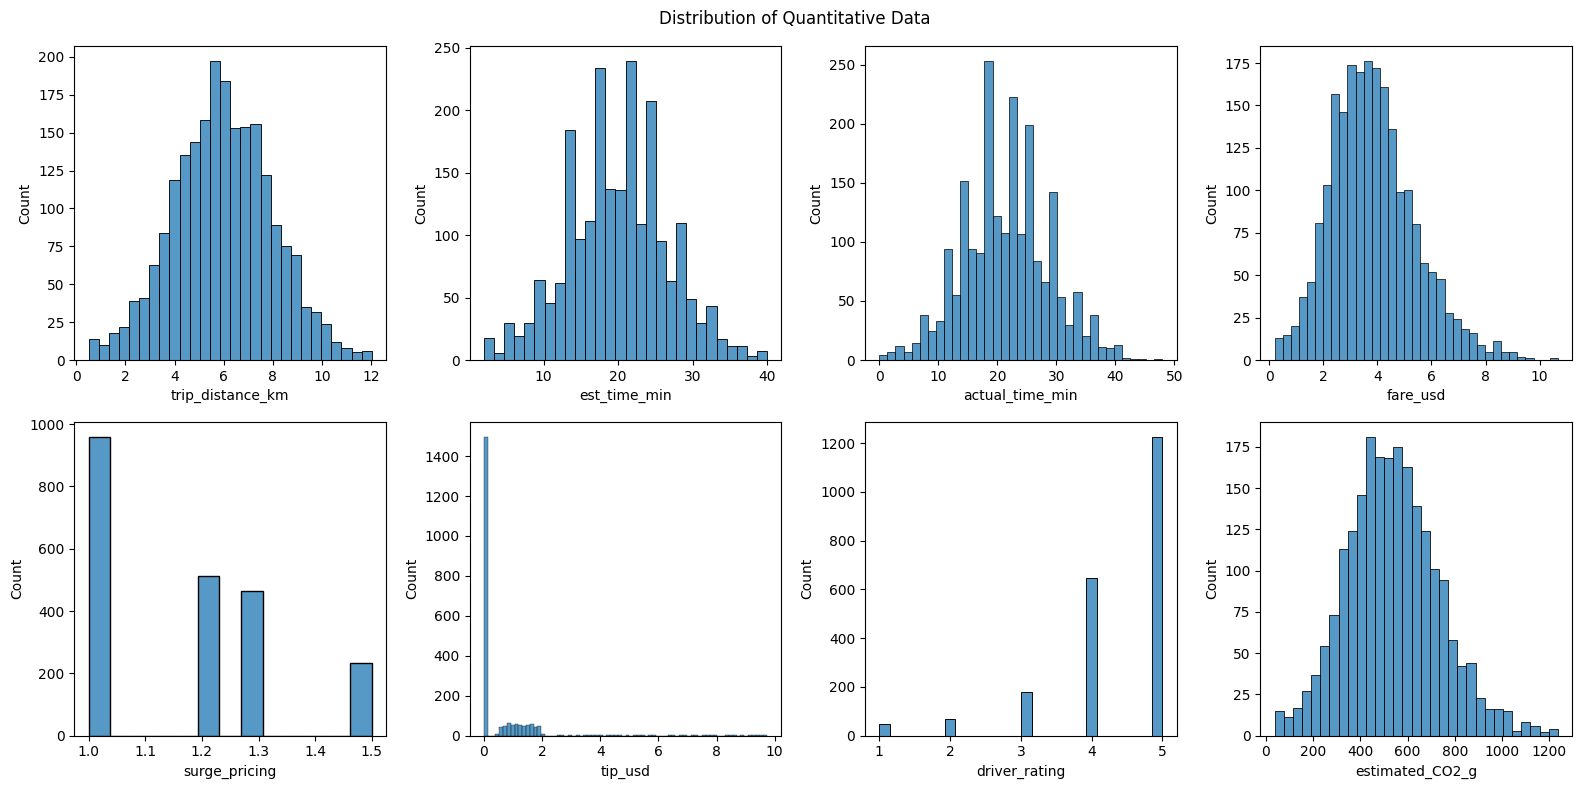

In [221]:
# Plot Quantitative Data
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

for i, var in enumerate(quan_cols):
    row = i // 4
    col = i % 4
    sns.histplot(data=data, x=var, ax=ax[row, col])

plt.suptitle("Distribution of Quantitative Data")
plt.tight_layout()

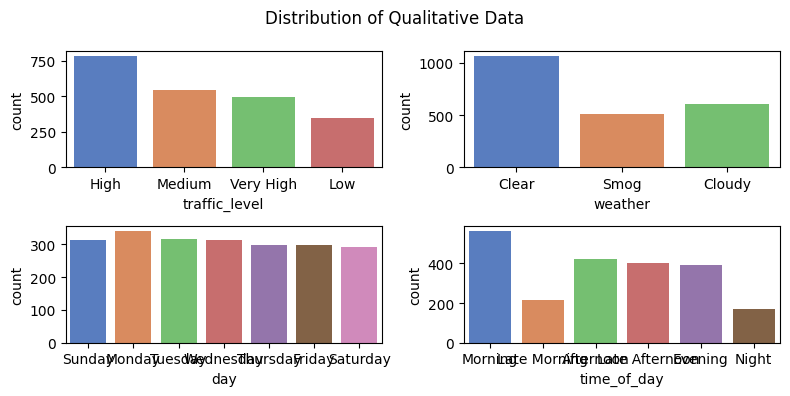

In [237]:
# Plot Qualtitative Data
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

for i, var in enumerate(qual_cols):
    row = i // 2
    col = i % 2
    sns.countplot(data, x=var, ax=ax[row, col], hue=var, palette='muted', legend=False)

plt.suptitle("Distribution of Qualitative Data")
plt.tight_layout()

In [ ]:
# Line Series of Request Time
# What time people request the most?

### 2. Diagnostic


### Questions for Diagnostic Analysis (Correlation & Hypothesis)
1. Relationship between Estimated and Actual Time
2. Relationship between 

0.009230616102467098


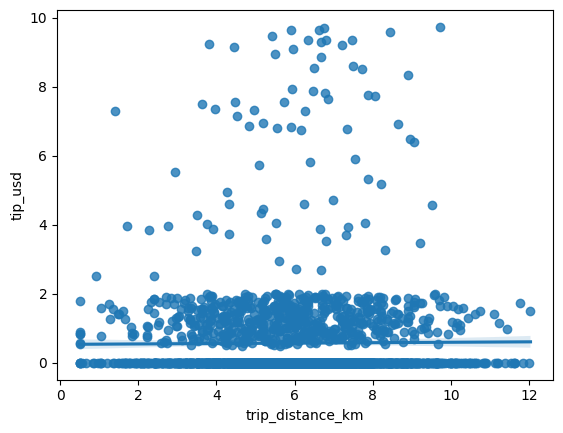

In [ ]:
# Relationship between Distance and Tip
sns.regplot(data, x='trip_distance_km', y='tip_usd')

                 est_time_min  actual_time_min
est_time_min           1.0000           0.9114
actual_time_min        0.9114           1.0000


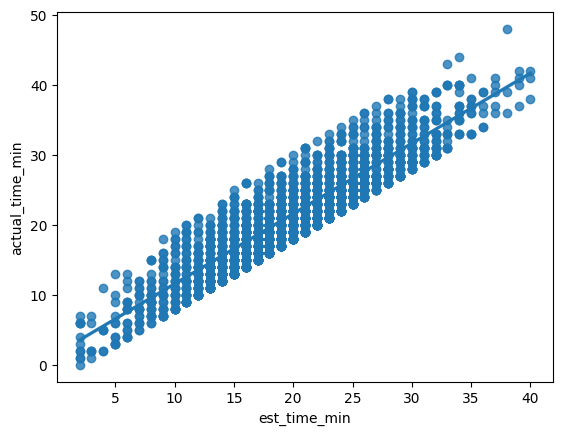

In [ ]:
# Est and Actual Time
sns.regplot(data, x='est_time_min', y='actual_time_min')
print(data[['est_time_min', 'actual_time_min']].corr())

# dont forget to Change the weights for this in the dataset!

<Axes: xlabel='Count', ylabel='driver_rating'>

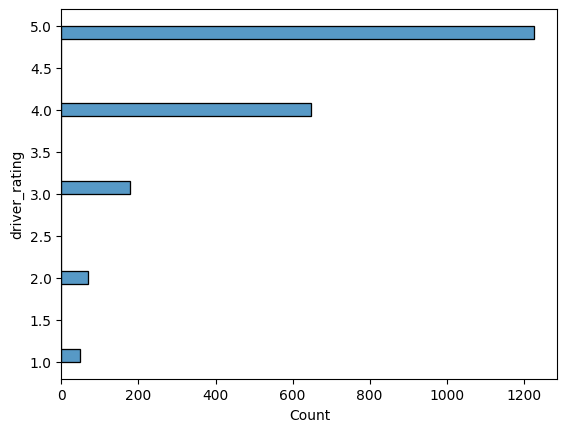

In [ ]:
# relationship between rating and tip
# data['driver_rating'].astype('object')
sns.histplot(data, y='driver_rating')

### 3. Predictive

### 4. Prescriptive